# Chip making for a subset of GB

This document extracts a series of chips for a region of GB and stores them as `numpy` arrays ready to be loaded by TensorFlow.

In [6]:
import tools


import geopandas
import contextily
import xarray, rioxarray
import numpy
import pandas
import pyogrio
from shapely.geometry import box
from dask.distributed import Client, LocalCluster


## Specs

In [7]:
specs = {
    'bb': box(321566, 365379, 468106, 437198),
    'chip_size': 32,
    'bands': [1, 2, 3], #RGB
    'mosaic_p': (
        '/home/jovyan/work/urbangrammar_samba/'
        'ghs_composite_s2/GHS-composite-S2.vrt'
    ),
    'spsig_p': (
        '/home/jovyan/work/urbangrammar_samba/spatial_signatures/'
        'signatures/'
        'signatures_combined_levels_simplified.gpkg'
    ),
    'tensor': (
        '/home/jovyan/work/urbangrammar_samba/'
        'spatial_signatures/chips/sample_32.npz'
    ),
    'folder': (
        '/home/jovyan/work/urbangrammar_samba/'
        'spatial_signatures/chips/32/'
    ),
}

## Load region

- Mosaic

In [8]:
r = rioxarray.open_rasterio(
    specs['mosaic_p'], chunks={'x': 1024, 'y': 1024}
)

- Region

In [9]:
region = r.sel(
    band=[1, 2, 3]
).rio.clip_box(
    *specs['bb'].bounds
).compute()

## Make chips

In [5]:
%%time
chips = tools.build_grid(
    region.coords['x'],
    region.coords['y'],
    specs['chip_size'],
    crs=region.rio.crs
)

CPU times: user 1.83 s, sys: 68.8 ms, total: 1.9 s
Wall time: 1.74 s


## Filter through signatures

- Read signature layer

In [6]:
%%time
spsig = pyogrio.read_dataframe(specs['spsig_p'])

CPU times: user 936 ms, sys: 274 ms, total: 1.21 s
Wall time: 2.64 s


- Join chips to signatures by `within` to keep only single-class chips

In [7]:
%%time
oc_chips = geopandas.sjoin(
    chips, 
    spsig[['signature_type', 'geometry']], 
    how='inner', 
    predicate='within'
)

CPU times: user 3.81 s, sys: 18.5 ms, total: 3.83 s
Wall time: 3.81 s


---

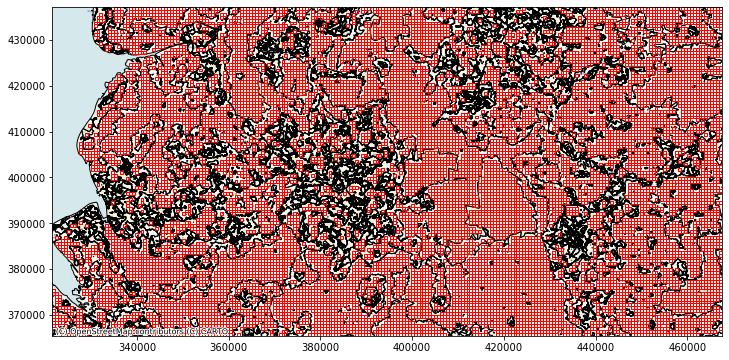

In [9]:
ax = spsig.plot(facecolor='none', edgecolor='k', figsize=(12, 12))
oc_chips.plot(facecolor='none', edgecolor='red', ax=ax)
minX, minY, maxX, maxY = oc_chips.total_bounds
ax.set_xlim((minX, maxX))
ax.set_ylim((minY, maxY))
contextily.add_basemap(
    ax, crs=oc_chips.crs, source=contextily.providers.CartoDB.Voyager
);

(365462.947432155, 437199.5895371777)

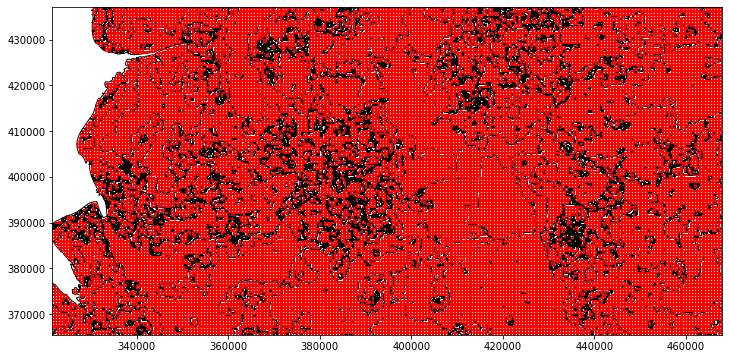

In [40]:
ax = spsig.plot(facecolor='none', edgecolor='k', figsize=(12, 12))
oc_chips.plot(facecolor='none', edgecolor='red', ax=ax)
minX, minY, maxX, maxY = oc_chips.total_bounds
ax.set_xlim((minX, maxX))
ax.set_ylim((minY, maxY))

## Load imagery into chips

In [78]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

<Client: 'tcp://127.0.0.1:44673' processes=16 threads=16, memory=125.54 GiB>

In [52]:
%time out = tools.bag_of_chips(oc_chips, specs, 16)

CPU times: user 5min 3s, sys: 6min 15s, total: 11min 18s
Wall time: 5min 53s


Shuffle

In [53]:
numpy.random.seed(42)

shuffled_idx = numpy.arange(0, out.shape[0])
numpy.random.shuffle(shuffled_idx)

out = out[shuffled_idx]

labels = oc_chips.signature_type.values[shuffled_idx].reshape((-1,1))

## Write to disk

Once ready, we store the array as a `.npz` file to be shipped to TensorFlow.

In [54]:
%%time
numpy.savez_compressed(specs["tensor"], labels=labels, chips=out)

CPU times: user 2min 41s, sys: 1min 57s, total: 4min 38s
Wall time: 1min 24s


# Spill chips to disk for out-of-core computation

In [15]:
%%time
# max value for normalisation
specs['max'] = int(region.quantile(.99))

CPU times: user 733 ms, sys: 135 ms, total: 867 ms
Wall time: 689 ms


In [9]:
client = Client(
    LocalCluster(n_workers=16, threads_per_worker=1)
)
client

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid st

<Client: 'tcp://127.0.0.1:36133' processes=16 threads=16, memory=125.54 GiB>

In [17]:
%%time
tools.spilled_bag_of_chips(oc_chips, specs, npartitions=16)

CPU times: user 38.7 s, sys: 5.86 s, total: 44.6 s
Wall time: 2min 14s


### Add shifted chips

Count the number of chips per class

In [21]:
import glob

for f in glob.glob(specs['folder'] + "*"):
    print(f[-3:], len(glob.glob(f + "/*")))

4_0 3090
9_2 11
2_0 379
9_0 18
7_0 26610
2_2 255
1_0 1576
8_0 76
6_0 271
2_1 243
3_0 4827
9_4 1
0_0 25571
5_0 2114


Add overlapping chips for some classes.

In [28]:
# translate
from itertools import product

subset_to_add = ["4_0", "9_2", "2_0", "9_0", "2_2", "1_0", "8_0", "6_0", "2_1", "9_4", "5_0"]

for x, y in product([0, 80, 160, 240], [80, 160, 240]):
    chips_translated = chips.copy()
    chips_translated.geometry = chips_translated.geometry.translate(xoff=x, yoff=y)
    chips_translated["X"] = chips_translated["X"] + x
    chips_translated["Y"] = chips_translated["Y"] + y

    oc_chips_sub = geopandas.sjoin(
        chips_translated, 
        spsig[['signature_type', 'geometry']][spsig.signature_type.isin(subset_to_add)], 
        how='inner', 
        predicate='within'
    )

    tools.spilled_bag_of_chips(oc_chips_sub, specs, npartitions=16)
    print(x, y, "done")

0 80 done
0 160 done
0 240 done
80 80 done
80 160 done
80 240 done
160 80 done
160 160 done
160 240 done
240 80 done
240 160 done
240 240 done


In [29]:
for f in glob.glob(specs['folder'] + "*"):
    print(f[-3:], len(glob.glob(f + "/*")))

4_0 39986
9_2 124
2_0 4931
9_0 218
7_0 26610
2_2 3168
1_0 20442
8_0 934
6_0 3617
2_1 3091
3_0 4827
9_4 7
0_0 25571
5_0 27725


A few more.

In [31]:
subset_to_add = ["9_2", "2_0", "9_0", "2_2", "8_0", "6_0", "2_1", "9_4"]

for x, y in product([0, 40, 120, 200], [40, 120, 200]):
    chips_translated = chips.copy()
    chips_translated.geometry = chips_translated.geometry.translate(xoff=x, yoff=y)
    chips_translated["X"] = chips_translated["X"] + x
    chips_translated["Y"] = chips_translated["Y"] + y

    oc_chips_sub = geopandas.sjoin(
        chips_translated, 
        spsig[['signature_type', 'geometry']][spsig.signature_type.isin(subset_to_add)], 
        how='inner', 
        predicate='within'
    )

    tools.spilled_bag_of_chips(oc_chips_sub, specs, npartitions=16)
    print(x, y, "done")

0 40 done
0 120 done
0 200 done
40 40 done
40 120 done
40 200 done
120 40 done
120 120 done
120 200 done
200 40 done
200 120 done
200 200 done


In [32]:
for f in glob.glob(specs['folder'] + "*"):
    print(f[-3:], len(glob.glob(f + "/*")))

4_0 39986
9_2 261
2_0 9459
9_0 407
7_0 26610
2_2 6108
1_0 20442
8_0 1824
6_0 6948
2_1 5947
3_0 4827
9_4 14
0_0 25571
5_0 27725


In [33]:
subset_to_add = ["9_2", "9_0", "9_4"]

for x, y in product([0, 20, 60, 100, 140, 180, 220, 260, 280, 300], [20, 60, 100, 140, 180, 220, 260, 280, 300]):
    chips_translated = chips.copy()
    chips_translated.geometry = chips_translated.geometry.translate(xoff=x, yoff=y)
    chips_translated["X"] = chips_translated["X"] + x
    chips_translated["Y"] = chips_translated["Y"] + y

    oc_chips_sub = geopandas.sjoin(
        chips_translated, 
        spsig[['signature_type', 'geometry']][spsig.signature_type.isin(subset_to_add)], 
        how='inner', 
        predicate='within'
    )

    tools.spilled_bag_of_chips(oc_chips_sub, specs, npartitions=16)
    print(x, y, "done")

0 20 done
0 60 done
0 100 done
0 140 done
0 180 done
0 220 done
0 260 done
0 280 done
0 300 done
20 20 done
20 60 done
20 100 done
20 140 done
20 180 done
20 220 done
20 260 done
20 280 done
20 300 done
60 20 done
60 60 done
60 100 done
60 140 done
60 180 done
60 220 done
60 260 done
60 280 done
60 300 done
100 20 done
100 60 done
100 100 done
100 140 done
100 180 done
100 220 done
100 260 done
100 280 done
100 300 done
140 20 done
140 60 done
140 100 done
140 140 done
140 180 done
140 220 done
140 260 done
140 280 done
140 300 done
180 20 done
180 60 done
180 100 done
180 140 done
180 180 done
180 220 done
180 260 done
180 280 done
180 300 done
220 20 done
220 60 done
220 100 done
220 140 done
220 180 done
220 220 done
220 260 done
220 280 done
220 300 done
260 20 done
260 60 done
260 100 done
260 140 done
260 180 done
260 220 done
260 260 done
260 280 done
260 300 done
280 20 done
280 60 done
280 100 done
280 140 done
280 180 done
280 220 done
280 260 done
280 280 done
280 300 done
3

In [35]:
counts = {}
for f in glob.glob(specs['folder'] + "*"):
    counts[f[-3:]] = len(glob.glob(f + "/*"))

In [36]:
counts

{'4_0': 39986,
 '9_2': 1211,
 '2_0': 9459,
 '9_0': 1892,
 '7_0': 26610,
 '2_2': 6108,
 '1_0': 20442,
 '8_0': 1824,
 '6_0': 6948,
 '2_1': 5947,
 '3_0': 4827,
 '9_4': 62,
 '0_0': 25571,
 '5_0': 27725}

In [37]:
group_mapping = [
    ['9_0', '9_1', '9_2', '9_4', '9_5', '2_0', '2_1', '2_2'],
    ['1_0', '3_0', '5_0', '6_0', '8_0'],
    ['0_0', '4_0', '7_0']
]

In [39]:
group_counts = {0:0, 1:0, 2:0}
for key, val in counts.items():
    for i, g in enumerate(group_mapping):
        if key in g:
            group_counts[i] += val

In [41]:
group_counts

{0: 24679, 1: 61766, 2: 92167}

move them around to a proper place

In [3]:
specs = {
    'chips': "../urbangrammar_samba/spatial_signatures/chips/32/",
}

In [14]:
split = (.6, .2, .2)

subfolders = glob.glob(specs["chips"] + "*")

for t in ["train", "validation", "secret"]:
    os.makedirs(specs["chips"] + t, exist_ok=True)

In [54]:
for sub in subfolders:
    for t in ["train", "validation", "secret"]:
        os.makedirs(f"{specs['chips']}{t}/{Path(sub).stem}", exist_ok=True)
    files = glob.glob(sub + "/*.tif")
    count = len(files)
    for f in files[:int(count * split[0])]:
        f = Path(f)
        shutil.move(f, str(f.parent.parent) + "/train/" + f.parent.stem + "/" + f.name)
    for f in files[int(count * split[0]):int(count * (split[0] + split[1]))]:
        f = Path(f)
        shutil.move(f, str(f.parent.parent) + "/validation/" + f.parent.stem + "/" + f.name)
    for f in files[int(count * (split[0] + split[1])):]:
        f = Path(f)
        shutil.move(f, str(f.parent.parent) + "/secret/" + f.parent.stem + "/" + f.name)
    print(sub, "done")

../urbangrammar_samba/spatial_signatures/chips/32/4_0 done
../urbangrammar_samba/spatial_signatures/chips/32/9_2 done
../urbangrammar_samba/spatial_signatures/chips/32/2_0 done
../urbangrammar_samba/spatial_signatures/chips/32/9_0 done
../urbangrammar_samba/spatial_signatures/chips/32/7_0 done
../urbangrammar_samba/spatial_signatures/chips/32/2_2 done
../urbangrammar_samba/spatial_signatures/chips/32/1_0 done
../urbangrammar_samba/spatial_signatures/chips/32/8_0 done
../urbangrammar_samba/spatial_signatures/chips/32/6_0 done
../urbangrammar_samba/spatial_signatures/chips/32/2_1 done
../urbangrammar_samba/spatial_signatures/chips/32/3_0 done
../urbangrammar_samba/spatial_signatures/chips/32/9_4 done
../urbangrammar_samba/spatial_signatures/chips/32/0_0 done
../urbangrammar_samba/spatial_signatures/chips/32/5_0 done


## Todo

- For GB, do the train/validation/secret split during spilling the chips, not afterwards.

In [13]:
int(region.sel(band=1).quantile(.99)), int(region.sel(band=2).quantile(.99)), int(region.sel(band=3).quantile(.99))

(1386, 1378, 1589)

In [14]:
int(region.sel(band=1).quantile(.02)), int(region.sel(band=2).quantile(.02)), int(region.sel(band=3).quantile(.02))

(376, 637, 801)